In [1]:
from sentence_transformers import SentenceTransformer, LoggingHandler
import numpy as np

In [3]:
model = SentenceTransformer('bert-base-nli-mean-tokens')


100%|██████████| 405M/405M [01:08<00:00, 5.89MB/s] 


In [28]:
sentences = ['can polycythemia cause stroke', 
    'Thrombotic strokes can affect large or small arteries in the brain. When a thrombotic stroke occurs in a small artery deep within the brain, the stroke is called a lacunar stroke. Embolic strokes - In an embolic stroke, a blood clot or other solid mass of debris travels to the brain, where it blocks a brain artery.',
     "Menstrual bleeding usually results from a decrease in natural hormone levels about 14 days after the ovulation, if you're not pregnant. The average woman takes one month to three months to start ovulating again after stopping the pill. Sometimes ovulation may occur sooner; other times, it may take longer.f you don't get your period for some time after stopping the pill chances are that you are either pregnant (do a pregnancy test!) or you did not ovulate. Even without getting your period first there might be a chance you are pregnant.",
     "ice cream"]
sentence_embeddings = model.encode(sentences)

In [29]:
len(sentence_embeddings)

4

In [30]:
sentence_embeddings[1].shape

(768,)

In [31]:
for sentence, embedding in zip(sentences, sentence_embeddings):
    print("Sentence:", sentence)
    print("Embedding:", embedding.shape)
    print("")

Sentence: can polycythemia cause stroke
Embedding: (768,)

Sentence: Thrombotic strokes can affect large or small arteries in the brain. When a thrombotic stroke occurs in a small artery deep within the brain, the stroke is called a lacunar stroke. Embolic strokes - In an embolic stroke, a blood clot or other solid mass of debris travels to the brain, where it blocks a brain artery.
Embedding: (768,)

Sentence: Menstrual bleeding usually results from a decrease in natural hormone levels about 14 days after the ovulation, if you're not pregnant. The average woman takes one month to three months to start ovulating again after stopping the pill. Sometimes ovulation may occur sooner; other times, it may take longer.f you don't get your period for some time after stopping the pill chances are that you are either pregnant (do a pregnancy test!) or you did not ovulate. Even without getting your period first there might be a chance you are pregnant.
Embedding: (768,)

Sentence: ice cream
Embed

In [32]:
sentence_embeddings[0].shape

(768,)

In [ ]:
# Evaluation below

In [33]:
from sklearn.metrics.pairwise import cosine_similarity

In [34]:
cosine_similarity(sentence_embeddings[0].reshape(-1,1).T, Y=sentence_embeddings[1:])

array([[0.6045091 , 0.4425732 , 0.12299903]], dtype=float32)

In [126]:
import pandas as pd

In [185]:
queries_file= '/run/media/root/Windows/Users/agnes/Downloads/data/msmarco/queries_od.csv'

df = pd.read_csv(queries_file)

df.head(3)

,qid,query,rel,type,doc
0,0,are cnn ratings falling,0,original,Mustard greens are also a good food choice for...
1,0,are cnn ratings falling,0,original,The only concessions Jay obtained was a surren...
2,0,are cnn ratings falling,0,original,Allen: Constitution Prevails Over President's ...


In [154]:
def calc_rr(rels_sorted, types_sorted, ttype='original', rel_label=1):
    indices = np.where(rels_sorted == rel_label)[0]
    #print(indices)
    original = np.where(types_sorted[indices] == ttype)[0]
    if len(original) == 0:
        raise Exception('no relevant docs of this type')
    return np.mean(1 / (indices[original]+1))


In [186]:

types = ['original', 'degree_2', 'degree_3', 'degree_4', 'degree_4_split', 'degree_8', 'degree_8_split']

rr_df = pd.DataFrame(columns=['qid'] + types + ['original_irrelevant'])

qids = list(set(df['qid']))
nr_qids = len(qids)
for i, qid in enumerate(qids):
    query_df = df[df['qid'] == qid].reset_index(drop=True)
    query = query_df['query'].iloc[0]
    print('query:', query)
    rels = query_df[query_df['rel'] == 1]['doc'].values.tolist()
   
    # TODO: abstract ranking part out
    ###
    embeddings = model.encode([query] + query_df['doc'].values.tolist())
    
    #TODO: use scipy.spatial.distance.cdist
    sims = cosine_similarity(embeddings[0].reshape(-1,1).T, 
                      Y=embeddings[1:])    
    indexed_sims = enumerate(sims.squeeze())   
    indexed_sims_sorted = sorted(indexed_sims, key=lambda x:x[1], reverse=True)
    indices_sorted = [x[0] for x in indexed_sims_sorted]
    ####
    
    docs_sorted = query_df.iloc[indices_sorted]
    
    row_to_add = [qid]
    for ttype in types:
        row_to_add.append(calc_rr(docs_sorted['rel'].values, docs_sorted['type'].values, ttype=ttype))
    row_to_add.append(calc_rr(docs_sorted['rel'].values, docs_sorted['type'].values, ttype='original', 
                      rel_label=0))
    rr_df = rr_df.append(pd.Series(row_to_add, index=rr_df.columns), ignore_index=True)
    
    if i % 5 ==  0:
        print('processed {:d} of {:d}'.format(i, nr_qids)
rr_df

query: are cnn ratings falling
query: can polycythemia cause stroke
query: cancer of the pancreas symptoms
query: amnesty define
query: can you have a high magnesium with high calcium
query: an electron group is defined as
query: can you get pregnant day one of your period
query: can ciprofloxacin be used to treat pneumonia
query: are most favored nation clauses legal
query: amnesty definition
query: how large is the canadian military
query: how much does it cost to run lines from heat pump
query: does cost less to run a heat pump
query: cost to install struts
query: average life of well pump
query: average cost to install fiber cement siding
query: cost of vacuum pump oil
query: cost to install a pond
query: american insulin pump cost
query: cost of a fire pit
query: foods that will help lower blood sugar
query: cost to install glued down carpet
query: cost of installing backup sump pump
query: what would it cost to install and buy a remote starter
query: how much does it cost to repl

query: biggest trees in california
query: how do we know that a tree should be cut down
query: what are the names of the varying kinds of maple trees
query: cost of dexlansoprazole
query: how many types of eucalyptus trees are there
query: how long can a peach cobbler last
query: is pizza considered fast food
query: types of fruit grafting techniques
query: what is a plum
query: what causes yellow spots on apple tree leaves
query: cold weather fruit trees
query: how long does it take pecan trees to grow
query: distance halifax to chicago
query: types of fruit trees
query: types of fruit curd
query: how to tell plums are ripe
query: average price of trees
query: what are aphids insects
query: what is the nutritional value of peaches
query: what is ashwagandha fruit used for
query: what zone do almond trees grow in
query: where are the oldest trees in the world
query: types of dutch elm trees
query: midway definition
query: what is plums good for
query: what is citrus
query: what wars wa

,qid,original,degree_2,degree_3,degree_4,degree_4_split,degree_8,degree_8_split,original_irrelevant
0,0.0,0.250000,0.149463,0.399731,0.076326,0.081496,0.044835,0.109524,0.038870
1,1.0,0.500000,0.172222,0.078781,0.294139,0.063667,0.084675,0.066787,0.049164
2,2.0,0.500000,0.365278,0.119339,0.073734,0.114441,0.081032,0.058098,0.035390
3,3.0,0.166667,0.126894,0.061609,0.286147,0.205449,0.110923,0.070547,0.044373
4,4.0,0.200000,0.350108,0.177509,0.180093,0.089171,0.040522,0.032058,0.040046
...,...,...,...,...,...,...,...,...,...
303,303.0,0.250000,0.065584,0.180746,0.081217,0.282068,0.061830,0.136285,0.053175
304,304.0,1.000000,0.249405,0.139881,0.051921,0.113005,0.049315,0.066728,0.039835
305,305.0,0.500000,0.191548,0.113158,0.068292,0.091604,0.051599,0.041683,0.103134
306,306.0,1.000000,0.153436,0.072521,0.151400,0.075000,0.148268,0.067251,0.040469


In [187]:
rr_df.describe()

,qid,original,degree_2,degree_3,degree_4,degree_4_split,degree_8,degree_8_split,original_irrelevant
count,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000
mean,153.500000,0.550023,0.177606,0.128559,0.108957,0.116654,0.069995,0.087153,0.064855
std,89.056162,0.376053,0.094887,0.076347,0.074900,0.084189,0.042772,0.070827,0.036044
min,0.000000,0.026316,0.042626,0.032904,0.032505,0.030078,0.027379,0.031087,0.032734
25%,76.750000,0.200000,0.102099,0.072496,0.058413,0.063242,0.044667,0.049616,0.040083
50%,153.500000,0.500000,0.156073,0.110017,0.085762,0.086304,0.056285,0.062147,0.048216
75%,230.250000,1.000000,0.225254,0.167593,0.125479,0.133581,0.080638,0.090919,0.076065
max,307.000000,1.000000,0.473958,0.437500,0.453125,0.481061,0.324405,0.423872,0.207395


In [ ]:
#TODO doe voor die andere queries waarbij de irrelevante docs uti dezelfde query gesampeld zijn

['original', 'degree_2', 'degree_3', 'degree_4', 'degree_8', 'original_irrelevant']



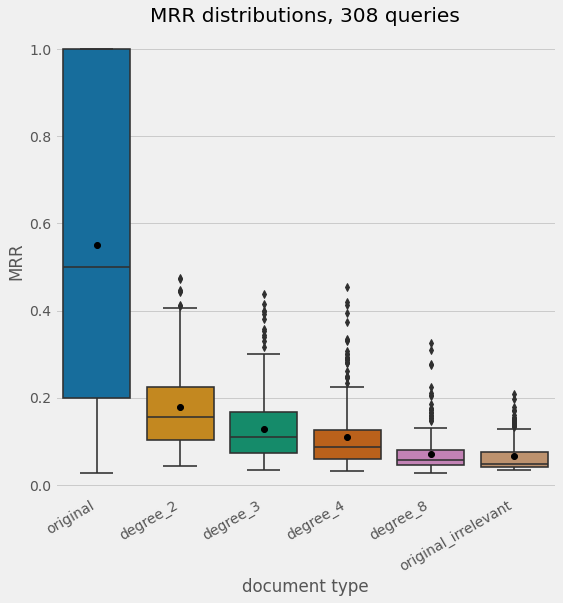

In [233]:

#TODO change column names

cols = ['original'] + \
       [x for x in rr_df.columns if x.startswith('degree_') and not x.endswith('split')] + \
       ['original_irrelevant']


print(cols)
rr_df_melted = pd.melt(rr_df, id_vars=['qid'], value_vars=cols)

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] =  1.6
         
plt.figure(figsize=(8,8))
ax = sns.boxplot(x="variable", y="value", data=rr_df_melted, palette="colorblind", showmeans=True,
                meanprops={"marker":"o","markerfacecolor":"black", "markeredgecolor":"black"})
ax.set_xticklabels(ax.get_xticklabels(),rotation=30, horizontalalignment='right')
plt.ylabel('MRR')
plt.xlabel('document type')
plt.title('MRR distributions, ' + str(len(set(rr_df_melted['qid']))) + ' queries')
print()

['degree_4', 'degree_4_split', 'degree_8', 'degree_8_split', 'original_irrelevant']



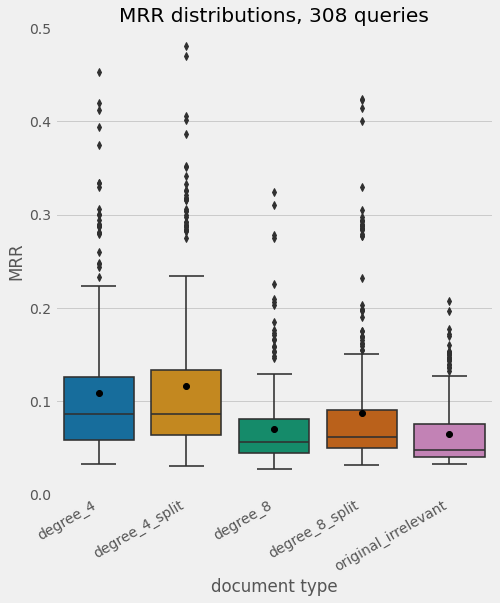

In [234]:
cols =  \
       ['degree_4', 'degree_4_split'] +\
       ['degree_8', 'degree_8_split'] + \
       ['original_irrelevant']


print(cols)
rr_df_melted = pd.melt(rr_df, id_vars=['qid'], value_vars=cols)

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] =  1.6
         
plt.figure(figsize=(7, 8))
ax = sns.boxplot(x="variable", y="value", data=rr_df_melted, palette="colorblind", showmeans=True,
                meanprops={"marker":"o","markerfacecolor":"black", "markeredgecolor":"black"})
ax.set_xticklabels(ax.get_xticklabels(),rotation=30, horizontalalignment='right')
plt.ylabel('MRR')
plt.xlabel('document type')
plt.title('MRR distributions, ' + str(len(set(rr_df_melted['qid']))) + ' queries')
plt.ylim(0,.5)
print()